In [24]:
import sys
import xarray as xr
import torch
import random
import numpy as np
import torchinfo
import importlib as imp
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import cartopy as ct
import cmasher as cmr
import cartopy.feature as cfeature
import regionmask

import warnings

warnings.filterwarnings("ignore")

import utils
import datamaker.data_loader as data_loader
from datamaker.data_generator import ClimateData
from datamaker.data_generator_transfer import ClimateDataTransfer

import datamaker.regions as regions
from trainer.trainer import Trainer
from model.model import TorchModel
import model.loss as module_loss
import model.metric as module_metric
import visuals.plots as plots
from shash.shash_torch import Shash

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")

python version = 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:37:07) [Clang 15.0.7 ]
numpy version = 1.24.4
xarray version = 2023.6.0
pytorch version = 2.4.1


## BASE MODEL

In [2]:
config = utils.get_config("exp1000")
seed = config["seed_list"][0]

In [3]:
# Load the data; split into train, val, test
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True

print("getting data ...")
data = ClimateData(
    config["datamaker"],
    expname=config["expname"],
    seed=seed,
    data_dir=config["data_dir"],
    figure_dir=config["figure_dir"],
    verbose=False,
)

getting data ...
YEAR REACHED:  [2001. 2007. 2004. 1998. 2014. 2003. 1990.]
(7, 251, 72, 144, 1)
YEAR REACHED:  [2007. 2012.]
(2, 251, 72, 144, 1)
YEAR REACHED:  [2000.]
(1, 251, 72, 144, 1)
(7, 251, 72, 144, 1)
(2, 251, 72, 144, 1)
(1, 251, 72, 144, 1)
YEAR REACHED:  [2009. 2007. 2004. 2002. 2014. 2003. 1994.]
(7, 251, 72, 144, 1)
YEAR REACHED:  [2007. 2012.]
(2, 251, 72, 144, 1)
YEAR REACHED:  [2004.]
(1, 251, 72, 144, 1)
(7, 251, 72, 144, 1)
(2, 251, 72, 144, 1)
(1, 251, 72, 144, 1)
YEAR REACHED:  [2026. 2007. 2004. 2017. 2016. 2003. 2017.]
(7, 251, 72, 144, 1)
YEAR REACHED:  [2028. 2017.]
(2, 251, 72, 144, 1)
YEAR REACHED:  [2004.]
(1, 251, 72, 144, 1)
(7, 251, 72, 144, 1)
(2, 251, 72, 144, 1)
(1, 251, 72, 144, 1)
YEAR REACHED:  [2036. 2034. 2035. 2037. 2058. 2029. 2048.]
(7, 251, 72, 144, 1)
YEAR REACHED:  [2038. 2038.]
(2, 251, 72, 144, 1)
YEAR REACHED:  [2022.]
(1, 251, 72, 144, 1)
(7, 251, 72, 144, 1)
(2, 251, 72, 144, 1)
(1, 251, 72, 144, 1)
YEAR REACHED:  [2100. 2064. 2063. 2

In [33]:
trainset = data_loader.CustomData(data.d_train)
valset = data_loader.CustomData(data.d_val)
testset = data_loader.CustomData(data.d_test)
obsset = data_loader.CustomData(data.d_obs)

In [34]:
LOSS_THRESHOLD = -0.1
exp_list = (
    "exp1001",
    "exp900",
    "exp901",
    "exp902",
    "exp903",
    "exp904",
    "exp905",
    "exp906",
)

# load the models
# ------------------------------------
df_metrics = pd.DataFrame()
for parent_exp_name in exp_list:

    config = utils.get_config(parent_exp_name)

    for seed in config["seed_list"]:

        model_name = utils.get_model_name(config["expname"], seed)

        # get base model metrics
        try:
            df = pd.read_pickle(config["output_dir"] + model_name + "_metrics.pickle")
        except:
            continue

        device = utils.prepare_device(config["device"])
        model = TorchModel(
            config=config["arch"], target=trainset.target
        )  # sets up model architecture
        model = utils.load_torch_model(
            model, config["model_dir"] + model_name + ".pt"
        )  # loads model weights from file
        model.to(device)  # sends model to GPU or CPU
        criterion = getattr(module_loss, config["criterion"])()
        print(f"loaded_model = {model_name}")

        with torch.inference_mode():
            output_val = model.predict(dataset=valset, batch_size=128, device=device)
            output_test = model.predict(dataset=testset, batch_size=128, device=device)
            data.d_obs["output"] = model.predict(
                dataset=obsset, batch_size=128, device=device
            )

        data.d_obs["output_median"] = Shash(data.d_obs["output"]).median().numpy()
        data.d_obs["output_lbar"] = Shash(data.d_obs["output"]).quantile(0.25).numpy()
        data.d_obs["output_hbar"] = Shash(data.d_obs["output"]).quantile(0.75).numpy()

        error_val = module_metric.custom_mae(output_val, data.d_val["y"])
        error_test = module_metric.custom_mae(output_test, data.d_test["y"])

        _, _, d_val, _ = module_metric.pit_d(output_val, data.d_val["y"])
        _, _, d_test, _ = module_metric.pit_d(output_test, data.d_test["y"])
        _, _, d_valtest, _ = module_metric.pit_d(
            np.append(output_val, output_test, axis=0),
            np.append(data.d_val["y"], data.d_test["y"], axis=0),
        )
        output_val = torch.tensor(output_val, dtype=torch.float32).to(device)
        target_val = torch.tensor(data.d_val["y"], dtype=torch.float32).to(device)
        loss_val = criterion(output_val, target_val)

        output_test = torch.tensor(output_test, dtype=torch.float32).to(device)
        target_test = torch.tensor(data.d_test["y"], dtype=torch.float32).to(device)
        loss_test = criterion(output_test, target_test)

        # loss_val = float(criterion(output_val, data.d_val["y"]).detach().cpu().numpy())
        # loss_test = float(criterion(output_test, data.d_test["y"]).detach().cpu().numpy())
        print(f"loss_val = {loss_val}")
        print(f"loss_test = {loss_test}")
        # loss_val = float(criterion(output_val, data.d_val["y"]).numpy())
        # loss_test = float(criterion(output_test, data.d_test["y"]).numpy())

        dict_df = {}
        dict_df["exp_name"] = parent_exp_name
        dict_df["rng_seed"] = seed

        dict_df["loss_test"] = float(loss_test)  # df["loss_test"][0]
        dict_df["error_test"] = df["error_test"][0]
        dict_df["d_test"] = df["d_test"][0]

        dict_df["loss_val"] = float(loss_val)  # df["loss_val"][0]
        dict_df["error_val"] = df["error_val"][0]
        dict_df["d_val"] = df["d_val"][0]

        dict_df["d_valtest"] = df["d_valtest"][0]

        del model

        # -----------------------------------------------
        # LOAD EVERYTHING INTO THE MAIN DATAFRAME
        df_metrics = pd.concat([df_metrics, pd.DataFrame(dict_df, index=[0])])

loaded_model = exp1001_seed3
loss_val = 3.6857192516326904
loss_test = 3.7801477909088135
loaded_model = exp1001_seed10
loss_val = 3.762087106704712
loss_test = 3.6929116249084473
loaded_model = exp1001_seed19
loss_val = 3.7474863529205322
loss_test = 3.933800458908081
loaded_model = exp1001_seed57
loss_val = 3.6704022884368896
loss_test = 3.7370619773864746
loaded_model = exp1001_seed68
loss_val = 3.8938229084014893
loss_test = 3.9981727600097656
loaded_model = exp900_seed3
loss_val = 3.7462589740753174
loss_test = 3.7961466312408447
loaded_model = exp900_seed10
loss_val = 3.8376317024230957
loss_test = 3.791956663131714
loaded_model = exp900_seed19
loss_val = 3.7751471996307373
loss_test = 3.9693245887756348
loaded_model = exp900_seed57
loss_val = 3.713992118835449
loss_test = 3.8314850330352783
loaded_model = exp900_seed68
loss_val = 3.6923727989196777
loss_test = 3.794663190841675
loaded_model = exp901_seed3
loss_val = 3.750349998474121
loss_test = 3.8448731899261475
loaded_model =

In [36]:
df_metrics

,exp_name,rng_seed,loss_test,error_test,d_test,loss_val,error_val,d_val,d_valtest
0,exp1001,3,3.780148,9.052173,0.014341,3.685719,9.029010,0.015922,0.013361
0,exp1001,10,3.692912,8.972908,0.024933,3.762087,8.809569,0.007903,0.010522
0,exp1001,19,3.933800,9.296656,0.016346,3.747486,8.953997,0.012320,0.008192
0,exp1001,57,3.737062,8.925025,0.024533,3.670402,8.849232,0.009442,0.005764
0,exp1001,68,3.998173,10.241033,0.010828,3.893823,10.209902,0.016263,0.008133
0,exp900,3,3.796147,9.612479,0.016876,3.746259,9.394123,0.006583,0.008202
0,exp900,10,3.791957,9.492892,0.024305,3.837632,9.540129,0.010702,0.012942
0,exp900,19,3.969325,10.058681,0.012572,3.775147,9.470932,0.011369,0.005803
0,exp900,57,3.831485,9.001595,0.026708,3.713992,8.958391,0.009549,0.009538
0,exp900,68,3.794663,9.268131,0.034998,3.692373,8.775963,0.013247,0.016462


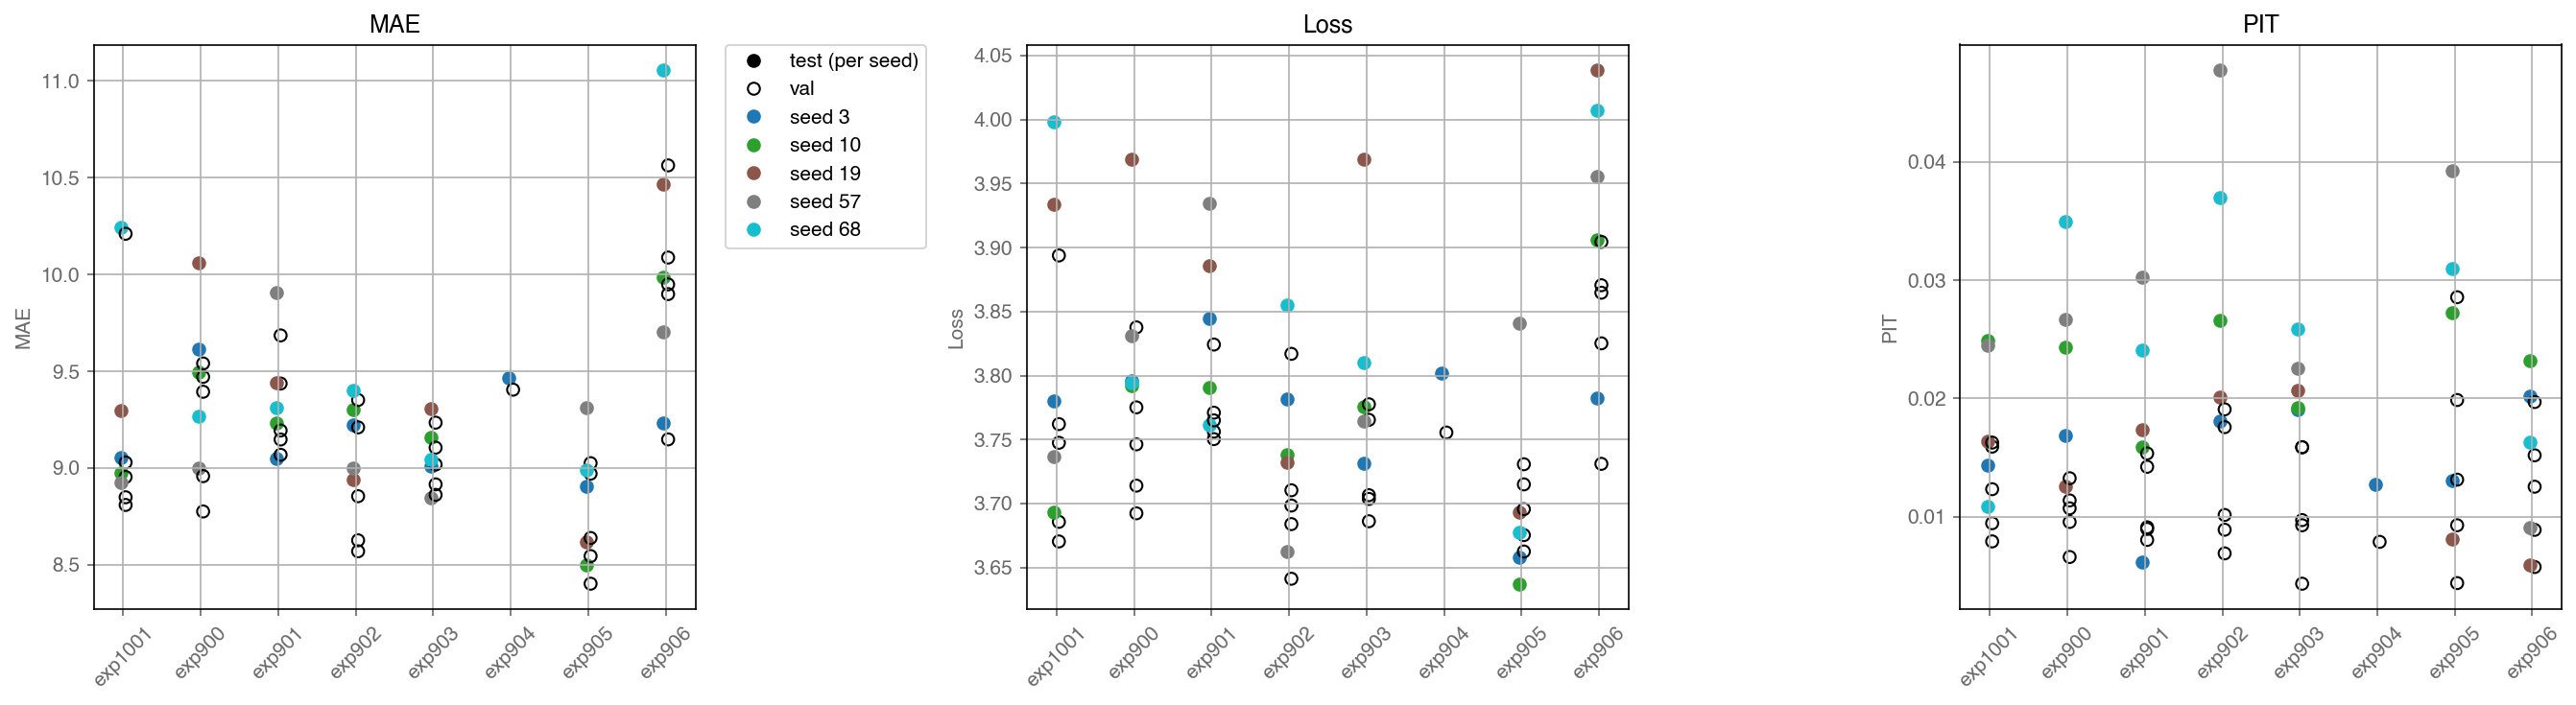

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.lines import Line2D

# Unique experiments and seeds
experiments = df_metrics["exp_name"].unique()
rng_seeds = sorted(df_metrics["rng_seed"].unique())
experiment_to_x = {exp: i for i, exp in enumerate(experiments)}

# Define a colormap for seeds
cmap = cm.get_cmap("tab10", len(rng_seeds))
seed_colors = {seed: cmap(i) for i, seed in enumerate(rng_seeds)}

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=False)

# (Title, test_col, val_col)
plot_info = [
    ("MAE", "error_test", "error_val"),
    ("Loss", "loss_test", "loss_val"),
    ("PIT", "d_test", "d_val"),
]

for ax, (title, test_col, val_col) in zip(axes, plot_info):
    for exp in experiments:
        subset = df_metrics[df_metrics["exp_name"] == exp]
        x_base = experiment_to_x[exp]

        for _, row in subset.iterrows():
            seed = row["rng_seed"]
            color = seed_colors[seed]

            # Plot test point (filled, seed color) — no label
            ax.scatter(x_base - 0.03, row[test_col], color=color, marker="o")

            # Plot val point (open black circle) — no label
            ax.scatter(
                x_base + 0.03,
                row[val_col],
                facecolors="none",
                edgecolors="black",
                marker="o",
            )

    ax.set_title(title)
    ax.set_xticks(range(len(experiments)))
    ax.set_xticklabels(experiments, rotation=45)
    ax.set_ylabel(title)
    ax.grid(True)

# Build legend handles
legend_elements = [
    Line2D([0], [0], marker="o", color="black", label="test (per seed)", linestyle=""),
    Line2D(
        [0],
        [0],
        marker="o",
        markerfacecolor="none",
        markeredgecolor="black",
        label="val",
        linestyle="",
    ),
]

# Add one entry per seed
for seed in rng_seeds:
    legend_elements.append(
        Line2D(
            [0],
            [0],
            marker="o",
            color=seed_colors[seed],
            label=f"seed {seed}",
            linestyle="",
        )
    )

# Show legend only once
axes[0].legend(
    handles=legend_elements,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    borderaxespad=0.0,
)

plt.tight_layout()
plt.show()